In [92]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from torch.optim.optimizer import Optimizer
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import random
import torch
import warnings 
warnings.filterwarnings('ignore')
from pytorch_lightning import seed_everything
import os
import gc
gc.collect()

167

# set_seed(42)

In [93]:
def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    seed_everything(seed)
    return random_state
random_state = set_seed(42)

Global seed set to 42


# MADGRAD

In [94]:
import math
from typing import TYPE_CHECKING, Any, Callable, Optional

if TYPE_CHECKING:
    from torch.optim.optimizer import _params_t
else:
    _params_t = Any

class MADGRAD(Optimizer):

    def __init__(
        self, params: _params_t, lr: float = 1e-2, momentum: float = 0.9, weight_decay: float = 0, eps: float = 1e-6,
    ):
        if momentum < 0 or momentum >= 1:
            raise ValueError(f"Momentum {momentum} must be in the range [0,1]")
        if lr <= 0:
            raise ValueError(f"Learning rate {lr} must be positive")
        if weight_decay < 0:
            raise ValueError(f"Weight decay {weight_decay} must be non-negative")
        if eps < 0:
            raise ValueError(f"Eps must be non-negative")

        defaults = dict(lr=lr, eps=eps, momentum=momentum, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @property
    def supports_memory_efficient_fp16(self) -> bool:
        return False

    @property
    def supports_flat_params(self) -> bool:
        return True

    def step(self, closure: Optional[Callable[[], float]] = None) -> Optional[float]:

        loss = None
        if closure is not None:
            loss = closure()

        if 'k' not in self.state:
            self.state['k'] = torch.tensor([0], dtype=torch.long)
        k = self.state['k'].item()

        for group in self.param_groups:
            eps = group["eps"]
            lr = group["lr"] + eps
            decay = group["weight_decay"]
            momentum = group["momentum"]

            ck = 1 - momentum
            lamb = lr * math.pow(k + 1, 0.5)

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if "grad_sum_sq" not in state:
                    state["grad_sum_sq"] = torch.zeros_like(p.data).detach()
                    state["s"] = torch.zeros_like(p.data).detach()
                    if momentum != 0:
                        state["x0"] = torch.clone(p.data).detach()

                if momentum != 0.0 and grad.is_sparse:
                    raise RuntimeError("momentum != 0 is not compatible with sparse gradients")

                grad_sum_sq = state["grad_sum_sq"]
                s = state["s"]

                # Apply weight decay
                if decay != 0:
                    if grad.is_sparse:
                        raise RuntimeError("weight_decay option is not compatible with sparse gradients")

                    grad.add_(p.data, alpha=decay)

                if grad.is_sparse:
                    grad = grad.coalesce()
                    grad_val = grad._values()

                    p_masked = p.sparse_mask(grad)
                    grad_sum_sq_masked = grad_sum_sq.sparse_mask(grad)
                    s_masked = s.sparse_mask(grad)

                    # Compute x_0 from other known quantities
                    rms_masked_vals = grad_sum_sq_masked._values().pow(1 / 3).add_(eps)
                    x0_masked_vals = p_masked._values().addcdiv(s_masked._values(), rms_masked_vals, value=1)

                    # Dense + sparse op
                    grad_sq = grad * grad
                    grad_sum_sq.add_(grad_sq, alpha=lamb)
                    grad_sum_sq_masked.add_(grad_sq, alpha=lamb)

                    rms_masked_vals = grad_sum_sq_masked._values().pow_(1 / 3).add_(eps)

                    s.add_(grad, alpha=lamb)
                    s_masked._values().add_(grad_val, alpha=lamb)

                    # update masked copy of p
                    p_kp1_masked_vals = x0_masked_vals.addcdiv(s_masked._values(), rms_masked_vals, value=-1)
                    # Copy updated masked p to dense p using an add operation
                    p_masked._values().add_(p_kp1_masked_vals, alpha=-1)
                    p.data.add_(p_masked, alpha=-1)
                else:
                    if momentum == 0:
                        # Compute x_0 from other known quantities
                        rms = grad_sum_sq.pow(1 / 3).add_(eps)
                        x0 = p.data.addcdiv(s, rms, value=1)
                    else:
                        x0 = state["x0"]

                    # Accumulate second moments
                    grad_sum_sq.addcmul_(grad, grad, value=lamb)
                    rms = grad_sum_sq.pow(1 / 3).add_(eps)

                    # Update s
                    s.data.add_(grad, alpha=lamb)

                    # Step
                    if momentum == 0:
                        p.data.copy_(x0.addcdiv(s, rms, value=-1))
                    else:
                        z = x0.addcdiv(s, rms, value=-1)

                        # p is a moving average of z
                        p.data.mul_(1 - ck).add_(z, alpha=ck)


        self.state['k'] += 1
        return loss

# LOAD DATA

In [95]:
train_df = pd.read_csv('Train_Product_Data_2021_0114.csv',index_col=0).drop(['Forward','Backward','label_for_train'],axis=1)
train_df = train_df.dropna(axis=0)
display(train_df.head(3))

val_df = pd.read_csv('Val_Product_Data_2021_0114.csv',index_col=0).drop(['Forward','Backward'],axis=1)
val_df = val_df.dropna(axis=0)
display(val_df.head(3))

,string_X_train,string_Y_1,string_Y_2,Y_label,row_id
586,"YUNGSOX 2100M 12MT USD1,015/MT USD12,180 YUNGS...",0,13,YUNGSOX 2100M,855
92,"TRIS 1,2-CYCLOHEXANE DICARBOXYLIC ACID,DI-ISON...",0,50,"TRIS 1,2-CYCLOHEXANE DICARBOXYLIC ACID,DI-ISON...",140
91,"TRIS . CIF PORT KLANG,MALAYSIA",0,4,TRIS,139


,string_X_train,string_Y_1,string_Y_2,Y_label,row_id
1,"COMMODITY: STYRENE MONOMER IN BULKQUANTITY: 3,...",11,34,STYRENE MONOMER IN BULK,1
2,"COMMODITY: STYRENE MONOMER IN BULKQUANTITY: 3,...",11,34,STYRENE MONOMER IN BULK,2
3,PP 3307UNC1 . TRADE TERMS: CFR ANY JAPANESE PORT,0,2,PP,10


# find_fail_sample and drop fail_sample

In [96]:
def find_fail_sample(df):
    fails = []
    for i in df.index:
        context = df.loc[i,'string_X_train']
        answer = df.loc[i,'Y_label']
        if answer not in context:
            fails.append(i)
    return fails
train_fails = find_fail_sample(train_df)
val_fails = find_fail_sample(val_df)
print(train_fails,val_fails)
display(val_df.loc[val_fails])
print(val_df.shape)
val_df = val_df.drop(val_fails,axis=0)
print(val_df.shape)

[] [342, 343, 344]


,string_X_train,string_Y_1,string_Y_2,Y_label,row_id
342,#NAME?,1,26,PURIFIED ISOPHTHALIC ACID,1238
343,#NAME?,1,26,PURIFIED ISOPHTHALIC ACID,1240
344,#NAME?,40,65,PURIFIED ISOPHTHALIC ACID,1241


(744, 5)
(741, 5)


# Model and Tokenizer Initialization

In [97]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
model = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer = T5Tokenizer.from_pretrained("t5-small")

In [98]:
input_ids = tokenizer('translate English to German: The house is wonderful.', return_tensors='pt').input_ids
labels = tokenizer('Das Haus ist wunderbar.', return_tensors='pt').input_ids
print(input_ids.shape)
print(labels.shape)
loss = model(input_ids=input_ids, labels=labels).loss
print(loss)

torch.Size([1, 11])
torch.Size([1, 6])
tensor(0.2542, grad_fn=<NllLossBackward>)


# PyTorch dataset

In [99]:
from torch.utils.data import Dataset,DataLoader

class SummarizeDataset(Dataset):
    def __init__(self, df ,tokenizer):         
        self.df =  df
        self.tokenizer = tokenizer
  
    def __len__(self):
        return self.df.shape[0]    
    
    def convert_to_features(self, example_batch):
        input_ = example_batch['string_X_train']
        target_ = example_batch['Y_label']
        source = self.tokenizer(input_,padding=True, truncation=True, return_tensors="pt")
        targets = self.tokenizer(target_,padding=True, truncation=True, return_tensors="pt")
        return source, targets
  
    def __getitem__(self, index):
        source, targets = self.convert_to_features(self.df.loc[index])
        source_ids = source["input_ids"].squeeze()
        target_ids = targets["input_ids"].squeeze()
        src_mask    = source["attention_mask"].squeeze()
        target_mask = targets["attention_mask"].squeeze()
        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}

In [102]:
train_dataset = SummarizeDataset(train_df.sample(100).reset_index(drop=True),tokenizer)
val_dataset = SummarizeDataset(val_df.sample(100).reset_index(drop=True),tokenizer)
train_loader = DataLoader(train_dataset, batch_size = 1, shuffle=True ,num_workers=4)
val_loader = DataLoader(val_dataset, batch_size = 1, shuffle=True ,num_workers=4)

In [103]:
for b in val_loader:
    print(b.keys())
    print(b['source_ids'].shape)
    print(b['target_ids'].shape)
    loss = model(input_ids=b['source_ids'], labels=b['target_ids']).loss
    print(loss)
    break

dict_keys(['source_ids', 'source_mask', 'target_ids', 'target_mask'])
torch.Size([1, 47])
torch.Size([1, 10])
tensor(1.1943, grad_fn=<NllLossBackward>)


# train loop

In [104]:
from torch.utils.data import DataLoader

# model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
model.to(device)
model.train()

# optimizer
optimizer = MADGRAD(model.parameters(),lr=5e-5)
gc.collect()

def train_step(model,batch,optimizer):
    model = model.to(device)
    model.train()
    
    # forward
    source_ids = batch['source_ids'].to(device)
    target_ids = batch['target_ids'].to(device)
    loss = model(input_ids=source_ids, labels=target_ids).loss
    
    # update model
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    gc.collect()
    return loss.item()

def val_step(model,batch,optimizer):
    model = model.to(device)
    model.eval()
    
    # forward
    source_ids = batch['source_ids'].to(device)
    target_ids = batch['target_ids'].to(device)
    loss = model(input_ids=source_ids, labels=target_ids).loss
    
    gc.collect()
    return loss.item()

def train_loop(model,train_loader,val_loader,optimizer,max_epochs=5,patience=3):
    history = {'train_loss':[],'val_loss':[]}
    best_loss = np.inf
    best_model = None
    not_improve_count = 0
    for epoch in tqdm(range(max_epochs)):    
        # reset this epoch loss equal to zero
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0

        # train one epoch and get train_loss
        for i,batch in enumerate(tqdm(train_loader)):
            epoch_train_loss += train_step(model,batch,optimizer)

        # val one epoch and get val_loss
        for j,batch in enumerate(tqdm(val_loader)):
            epoch_val_loss += val_step(model,batch,optimizer)

        # record loss history
        history['train_loss'].append(epoch_train_loss/i)
        history['val_loss'].append(epoch_val_loss/j)

        # print this epoch's infomation
        print(f'epoch:{epoch} train_loss:{epoch_train_loss/i} val_loss:{epoch_val_loss/j}')

        # save best_model (if current val_loss <= best_loss)
        if history['val_loss'][-1] <= best_loss: 
            best_model = deepcopy(model.eval())
            best_loss = history['val_loss'][-1]
            print(f'save best_model now_val_best_loss is:{best_loss}')

        if history['val_loss'][-1] > best_loss:
            not_improve_count += 1
            print(f'not_improve_count:{not_improve_count}')
            if not_improve_count > patience:
                print('early_stoping')
                break

    # GET best_model.eval()
    model = best_model.eval()
    return model,history

cuda


In [105]:
model,history = train_loop(model,train_loader,val_loader,optimizer,max_epochs=5,patience=3)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

epoch:0 train_loss:1.0519795889467602 val_loss:0.6375880972435227
save best_model now_val_best_loss is:0.6375880972435227


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

epoch:1 train_loss:0.4420904557342933 val_loss:0.7273525309683097
not_improve_count:1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

epoch:2 train_loss:0.38638912559947886 val_loss:0.47769579666694906
save best_model now_val_best_loss is:0.47769579666694906


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

epoch:3 train_loss:0.23701749963102617 val_loss:0.554733173497788
not_improve_count:2


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

epoch:4 train_loss:0.158676292333338 val_loss:0.5618590366311672
not_improve_count:3


# loss curve

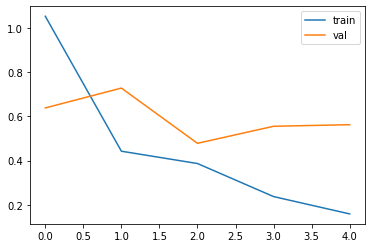

In [106]:
plt.plot(history['train_loss'],label='train')
plt.plot(history['val_loss'],label='val')
plt.legend()
plt.show()

# question-answering pipeline

In [107]:
from transformers import pipeline
nlp = pipeline("summarization", model=model.to('cpu'), tokenizer=tokenizer)

In [110]:
nlp(val_df.iloc[0]['string_X_train'])

Your max_length is set to 200, but you input_length is only 66. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': 'STYRENE MONOMER, 3,000.000 MT +/-5% UNIT PRICE: USD713.25/MTPRICE TERMS'}]

In [111]:
val_df.iloc[0]['Y_label']

'STYRENE MONOMER IN BULK'

# test

In [112]:
def test_model(df):
    table = pd.DataFrame()
    for i in tqdm(df.index):
        sample = df.loc[[i]]
        string_X_train = sample['string_X_train'].values[0]
        Y_label = sample['Y_label'].values[0]
        predict = nlp(string_X_train)[0]['summary_text']
        row = pd.DataFrame({'label':Y_label,'predict:':predict},index=[i])
        if Y_label == predict:
            row['是否全對'] = 'Yes'
        else:
            row['是否全對'] = 'No'
        table = table.append(row)
        i += 1
    return table

# 最後讓我們來看看模型在驗證集上的表現

In [114]:
all_res = test_model(val_df.sample(5))
all_res

  0%|          | 0/5 [00:00<?, ?it/s]

Your max_length is set to 200, but you input_length is only 92. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 200, but you input_length is only 56. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Token indices sequence length is longer than the specified maximum sequence length for this model (951 > 512). Running this sequence through the model will result in indexing errors
Your max_length is set to 200, but you input_length is only 82. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 200, but you input_length is only 78. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


,label,predict:,是否全對
253,EVA TAISOX 7350M,EVA TAISOX 7470M QUANTITY: 25.00MTUNIT PRICE: ...,No
362,POLYCARBONATE RESIN,POLYCARBONATE RESIN PC+GF 20% AC2120 . HIGH IM...,No
644,ABS RESINS,"BENEFICIARY'S SIGNED COMMERCIAL INVOICE, PAKIS...",No
632,ETHYL ACRYLATE,ETHYL ACRYLATE PER BENEFICIARYS SALES CONTRACT...,No
215,EVA TAISOX 7350M,EVA TAISOX 7470M QUANTITY: 275.00MTS UNIT PRIC...,No


# claculate acc and jaccard

In [115]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

display(all_res['是否全對'].value_counts())
acc = all_res['是否全對'].value_counts()['Yes']/len(val_df)
print('acc:',acc)
jaccard_avg_score = np.mean([ get_jaccard_sim(all_res.label.loc[i],all_res['predict:'].loc[i]) for i in all_res.index])
print('jaccard_avg_score:',jaccard_avg_score)

No    5
Name: 是否全對, dtype: int64

KeyError: 'Yes'